## Założenia projektu

W ramach projektu anaizowane będą ceny akcji spółek, których jednym z rodzajów działaności jest streaming filmów i seriali:
* Netflix
* Apple (Apple TV)
* Warner Bros (HBO)
* Disney (Disney+)
* Amazon (Amazon Prime)
* CBS (Showtime)

Jako dodatkowa zmienna objaśniająca (poza samym szeregiem czasowym tj. historycznymi cenami akcji) uwzględniona zostanie liczba aktywnych subskrypcji ich serwisów streamingowych.
Dane na temat cen spółek zostaną pozyskane ze strony https://www.nasdaq.com/ z wykorzystaniem biblioteki przeznaczonej dla języka Python i klucza API wygenerowanego dla konta studenckiego

Dane na temat liczby uzytkowników poszczególnych platform pozyskane zostaną z innych źródeł (Statista). Te dane przedstawione są w formie kwartalnej.
* Netflix - https://www.statista.com/statistics/250934/quarterly-number-of-netflix-streaming-subscribers-worldwide/
* Apple TV - 
* HBO - https://www.businessofapps.com/data/hbo-max-statistics/ https://www.statista.com/statistics/539290/hbo-now-subscribers/
* Disney+ - https://www.statista.com/statistics/1095372/disney-plus-number-of-subscribers-us/
* Amazon Prime - https://techjury.net/blog/amazon-prime-statistics/ https://www.statista.com/statistics/504687/number-of-amazon-prime-subscription-households-usa/
* Showtime - https://www.statista.com/statistics/1047393/cbs-all-access-subscribers-us/

In [18]:
# %pip install Nasdaq-Data-Link

In [81]:
import nasdaqdatalink
import requests
import pandas as pd
import warnings
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm

warnings.filterwarnings('ignore')

#Wygenerowany klucz dla konta
nasdaqdatalink.ApiConfig.api_key = "ibWexyU5CGhGxu2FxAT-"


### Sprawdzenie dostępnych baz dnaych

In [2]:
databases = pd.DataFrame(requests.get('https://data.nasdaq.com/api/v3/databases?download_type=full&api_key=ibWexyU5CGhGxu2FxAT-').json()['databases'])
print(databases.shape)
databases.head(2)

(91, 11)


,id,name,database_code,description,datasets_count,downloads,premium,image,favorite,url_name,exclusive
0,13111,Global Dairy Trade,GDT,,702,370399,False,http://d360wc4uc6n3i9.cloudfront.net/images/de...,False,global-dairy-trade,False
1,454,Warsaw Stock Exchange,WARSAWSE,WIG20 index has been calculated since April 16...,35,14867,False,http://d360wc4uc6n3i9.cloudfront.net/images/de...,False,warsaw-stock-exchange,False


In [3]:
databases.loc[databases['database_code']=='WIKI']

,id,name,database_code,description,datasets_count,downloads,premium,image,favorite,url_name,exclusive


WIKI/NFLX - Netflix

In [4]:
# netflix_data = nasdaqdatalink.get("WIKI/NFLX",rows=10)
# wbd_data = nasdaqdatalink.get("WIKI/WBD",rows=10)

In [5]:
netflix_data = pd.read_csv('data/Netflix.csv')
amazon_data = pd.read_csv('data/Amazon.csv')
disney_data = pd.read_csv('data/Disney.csv')
showtime_data = pd.read_csv('data/Paramount_Showtime.csv')
hbo_data = pd.read_csv('data/WBD.csv')


In [6]:
hbo_data['Open'] = hbo_data['Open'].str.replace('$','').astype(float)
netflix_data['Open'] = netflix_data['Open'].str.replace('$','').astype(float)
amazon_data['Open'] = amazon_data['Open'].str.replace('$','').astype(float)
disney_data['Open'] = disney_data['Open'].str.replace('$','').astype(float)
showtime_data['Open'] = showtime_data['Open'].str.replace('$','').astype(float)

In [7]:
hbo_data = hbo_data.iloc[::-1]
netflix_data = netflix_data.iloc[::-1]
amazon_data = amazon_data.iloc[::-1]
disney_data = disney_data.iloc[::-1]
showtime_data = showtime_data.iloc[::-1]

In [8]:
datasets = {'hbo':hbo_data,
            'netflix':netflix_data,
            'showtime':showtime_data,
            # 'amazon':amazon_data,
            'disney':disney_data}
for key,value in datasets.items():
    value['Date'] = pd.to_datetime(value['Date'],format='%m/%d/%Y')
    value['Quarter'] = value['Date'].dt.to_period('Q')
    value_out = value.loc[value['Date'].dt.date.between(datetime.date(2020,1,1),datetime.date(2022,6,30))]
    value_out.drop(['Close/Last','High','Low'],axis=1,inplace=True)
    datasets[key] = value_out
    

### Dodanie zmiennej z liczbą subskrypcji wyrazoną kwartalnie

In [9]:
netflix_subs = pd.read_excel('data/subscribers/Netflix_subscribers.xlsx',sheet_name='data_prepared')
amazon_subs = pd.read_excel('data/subscribers/Amazon_prime_users.xlsx',sheet_name='data_prepared')
disney_subs = pd.read_excel('data/subscribers/disney_plus.xlsx',sheet_name='data_prepared')
showtime_subs = pd.read_excel('data/subscribers/Paramount.xlsx',sheet_name='data_prepared')
hbo_subs = pd.read_excel('data/subscribers/hbo_worldwide.xlsx',sheet_name='data_prepared')

In [10]:
netflix_subs['Quarter'] = netflix_subs['Time'].dt.to_period('Q')
# amazon_subs['Quarter'] = amazon_subs['Time'].dt.to_period('Q')
disney_subs['Quarter'] = disney_subs['Time'].dt.to_period('Q')
showtime_subs['Quarter'] = showtime_subs['Time'].dt.to_period('Q')
hbo_subs['Quarter'] = hbo_subs['Time'].dt.to_period('Q')

In [11]:
datasets['hbo'] = pd.merge(datasets['hbo'],hbo_subs,on='Quarter')[['Date','Open','Volume','NO(milions)']]
datasets['netflix'] = pd.merge(datasets['netflix'],netflix_subs,on='Quarter')[['Date','Open','Volume','NO(milions)']]
datasets['disney'] = pd.merge(datasets['disney'],disney_subs,on='Quarter')[['Date','Open','Volume','NO(milions)']]
datasets['showtime'] = pd.merge(datasets['showtime'],showtime_subs,on='Quarter')[['Date','Open','Volume','NO(milions)']]
# datasets['amazon'] = pd.merge(datasets['amazon'],amazon_subs,on='Quarter')[['Date','Open','Volume','NO(milions)']]

## Testy statystyczne ceny otwarcia

[]

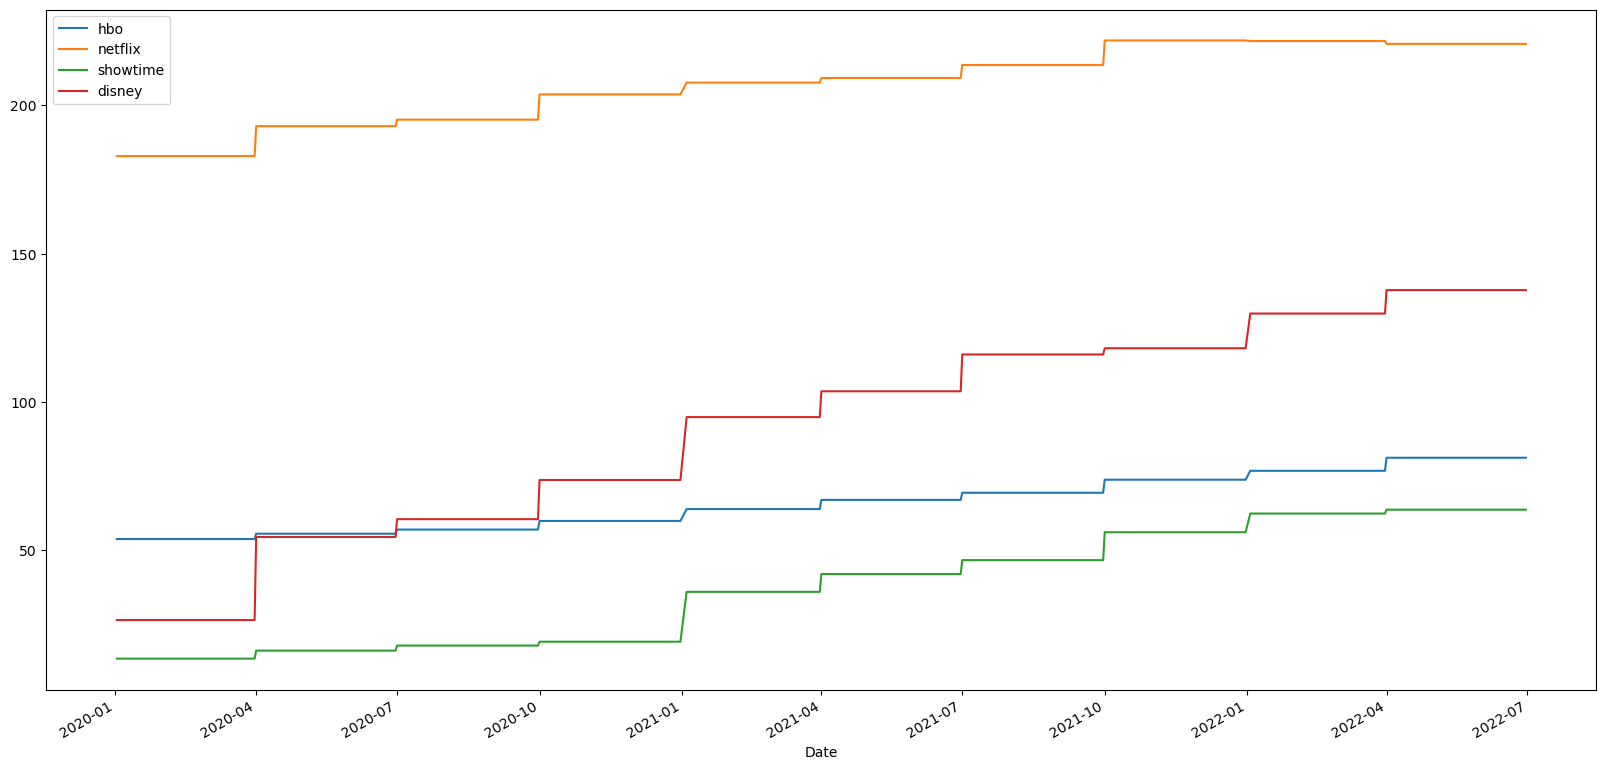

In [12]:
fig,ax = plt.subplots(figsize=(20,10))
for key,value in datasets.items():
    value.plot(ax = ax, x='Date',y='NO(milions)',label=key)

plt.plot()


[]

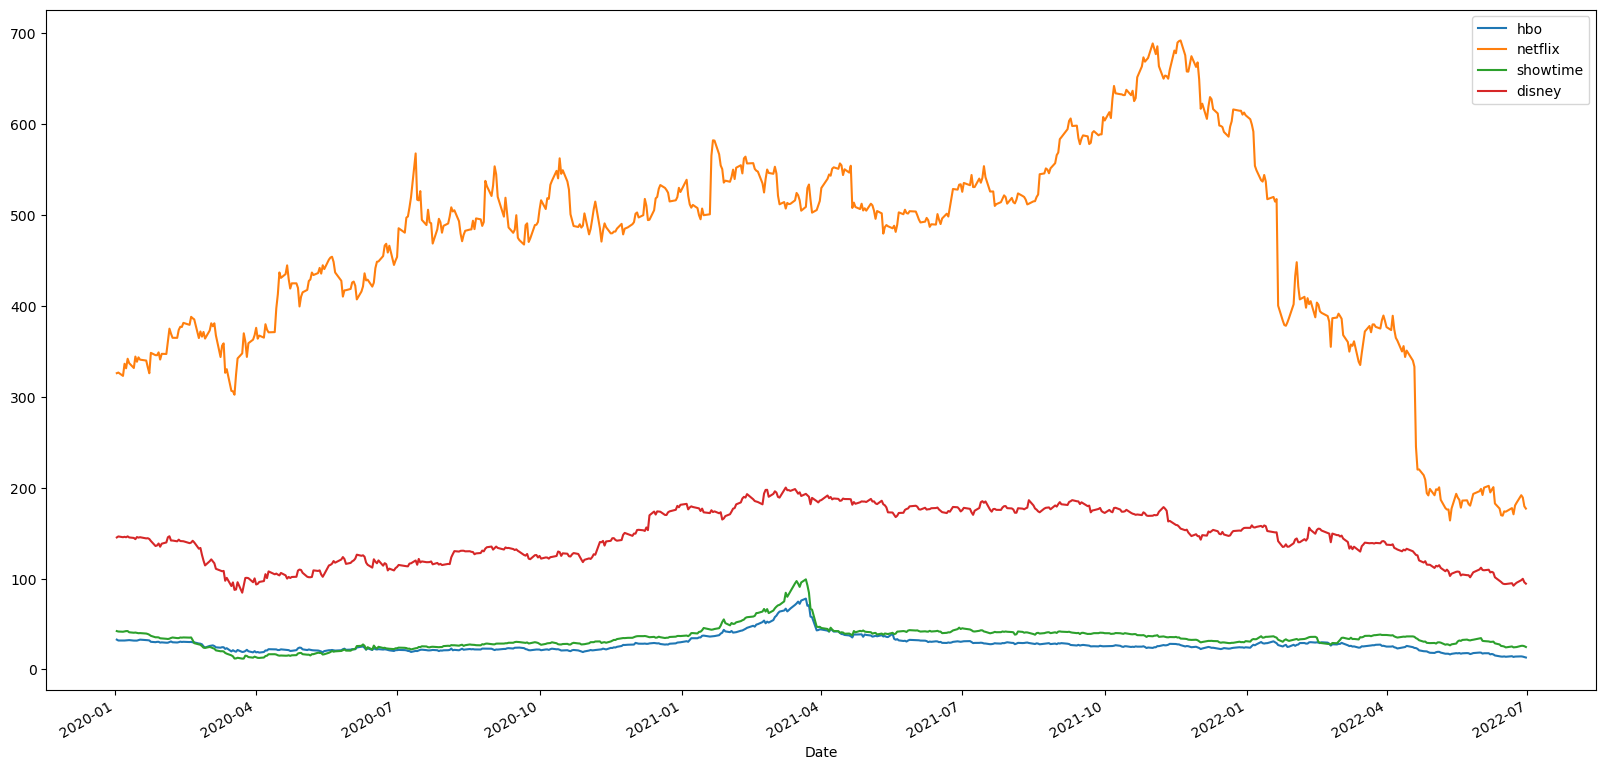

In [13]:
fig,ax = plt.subplots(figsize=(20,10))
for key,value in datasets.items():
    value.plot(ax = ax, x='Date',y='Open',label=key)

plt.plot()


### Test normlanosci rozkładu

In [14]:
from scipy.stats import kstest

def test_normalnosci_rozkladu(data): 
    res = kstest(data,'norm')
    print(res)
    if res[1]<0.05:
        print('Rozkład NIE JEST rozkładem normalnym')
    else:
        print('Rozkład JEST rozkładem normalnym')
    print(20*'-')


print('Wyniki testów Kołmogorova-Smirnova')
print(20*'-')
print(20*'-')
for name,data in datasets.items():
    print(name.title())
    test_normalnosci_rozkladu(data['Open'])
    

Wyniki testów Kołmogorova-Smirnova
--------------------
--------------------
Hbo
KstestResult(statistic=1.0, pvalue=0.0)
Rozkład NIE JEST rozkładem normalnym
--------------------
Netflix
KstestResult(statistic=1.0, pvalue=0.0)
Rozkład NIE JEST rozkładem normalnym
--------------------
Showtime
KstestResult(statistic=1.0, pvalue=0.0)
Rozkład NIE JEST rozkładem normalnym
--------------------
Disney
KstestResult(statistic=1.0, pvalue=0.0)
Rozkład NIE JEST rozkładem normalnym
--------------------


### Test stacjonarności

In [15]:
from statsmodels.tsa.stattools import adfuller

def test_stacjonarnosci(data): 
    res = adfuller(data)
    print(res)
    if res[1]<=0.05:
        print('Rozkład JEST stacjonarny')
    else:
        print('Rozkład NIE JEST stacjonarny')
    print(20*'-')


print('Wyniki testów stacjonarności')
print(20*'-')
print(20*'-')
for name,data in datasets.items():
    print(name.title())
    test_stacjonarnosci(data['Open'])
    

Wyniki testów stacjonarności
--------------------
--------------------
Hbo
(-2.291221010520913, 0.17481500512258596, 12, 616, {'1%': -3.4410103235939746, '5%': -2.866243374831338, '10%': -2.5692748053002195}, 1983.5656663675109)
Rozkład NIE JEST stacjonarny
--------------------
Netflix
(-0.46783059854837267, 0.8981427410596268, 0, 628, {'1%': -3.4408057813848147, '5%': -2.866153285929353, '10%': -2.569226804028561}, 4813.012027785948)
Rozkład NIE JEST stacjonarny
--------------------
Showtime
(-2.3846045873814363, 0.146128879706734, 13, 615, {'1%': -3.4410277306083668, '5%': -2.8662510413264357, '10%': -2.569278890210853}, 2316.502983367551)
Rozkład NIE JEST stacjonarny
--------------------
Disney
(-0.6190401880684023, 0.8666214244763906, 1, 627, {'1%': -3.440822526288827, '5%': -2.8661606613087542, '10%': -2.5692307337540603}, 3145.409357163393)
Rozkład NIE JEST stacjonarny
--------------------


### Test autokorelacji

In [16]:
from statsmodels.stats.stattools import durbin_watson

def test_autokorelacji(wynik): 
    if 0<=wynik<1:
        print('Mocna dodania autokorelacja')
    elif 1<wynik<=1.8:
        print('Dodania autokorelacja')
    elif 1.8<wynik<=2.2:
        print('Brak autokorelacji')
    elif 2.2<wynik<=3:
        print('Ujemna autokorelacja')
    else:
        print('Mocno ujemna autokrelacja')
    print(20*'-')

print('Wyniki testów autokorelacji')
print(20*'-')
print(20*'-')
for name,data in datasets.items():
    print(name.title())
    test_autokorelacji(durbin_watson(data['Volume']))

Wyniki testów autokorelacji
--------------------
--------------------
Hbo
Mocna dodania autokorelacja
--------------------
Netflix
Mocna dodania autokorelacja
--------------------
Showtime
Mocna dodania autokorelacja
--------------------
Disney
Mocna dodania autokorelacja
--------------------


### Korelacja zmiennych ceny otwarcia i liczby subskrybentów

In [17]:
from scipy.stats import spearmanr


def test_korelacji(data): 
    res = spearmanr(data['Open'],data['NO(milions)'])
    print(res)
    if res[0].round(1)==0:
        print('Brak korelacji')
    elif 0<=res[0].round(1)<=0.5:
        print('Niska korelacja dodania')
    elif 0.5<res[0].round(1)<=1:
        print('Wysoka korelacja dodatnia')
    elif -0.5<res[0].round(1)<=0:
        print('Niska korelacja ujemna')
    else:
        print('Wysoka korelacja ujemna')
    print(20*'-')
    print(20*'-')


print('Wyniki testów korelacji zmiennych')
print(20*'-')
print(20*'-')
for name,data in datasets.items():
    print(name.title())
    test_korelacji(data)

Wyniki testów korelacji zmiennych
--------------------
--------------------
Hbo
SpearmanrResult(correlation=0.010945307819552394, pvalue=0.7841083616784577)
Brak korelacji
--------------------
--------------------
Netflix
SpearmanrResult(correlation=0.344496869092994, pvalue=5.7630111554248065e-19)
Niska korelacja dodania
--------------------
--------------------
Showtime
SpearmanrResult(correlation=0.3189457468740985, pvalue=2.4385307115109247e-16)
Niska korelacja dodania
--------------------
--------------------
Disney
SpearmanrResult(correlation=0.23330106199374331, pvalue=3.1916209309354743e-09)
Niska korelacja dodania
--------------------
--------------------


### Statystyki podsumowujące

In [18]:
import statsmodels.api as sm

print('Podsumowane statystyki')
print(20*'-')
print(20*'-')
for name,data in datasets.items():
    print(name.title())
    print(data['Open'].describe())
    X = sm.add_constant([x for x in range(data.shape[0])])
    y = data['Open'].to_list()
    reg = sm.OLS(y, X).fit()
    print(reg.summary())
    print(20*'-')


Podsumowane statystyki
--------------------
--------------------
Hbo
count    629.000000
mean      27.837102
std        9.662457
min       13.120000
25%       21.940000
50%       25.750000
75%       29.880000
max       77.980000
Name: Open, dtype: float64
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.240
Date:                Mon, 17 Apr 2023   Prob (F-statistic):              0.266
Time:                        13:25:49   Log-Likelihood:                -2318.1
No. Observations:                 629   AIC:                             4640.
Df Residuals:                     627   BIC:                             4649.
Df Model:                           1                                         
Covariance Type:            nonro

Uwagi: czy stawiane prognonozy będą w okresie kwartalnym? czy zamierzają Panowie zbudować model z różnymi częstotliwościami? Jakich okresów będą dotyczyły analizy i prognozy? czy w tym okresie występują jakies zmiany strukturalne?

# Część 2 - Wstępne modelowanie

In [312]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [67]:
datasets.keys()

dict_keys(['hbo', 'netflix', 'showtime', 'disney'])

## Regresja liniowa

In [15]:
open_data_values = datasets['netflix']['Open'].values

In [16]:
X = []
Y = []
for i in range(7,len(open_data_values)):
    X.append(list(open_data_values[i-7:i]))
    Y.append(open_data_values[i])


In [17]:
X = np.array(X)
Y = np.array(Y)

In [18]:
X_train_full, X_test, Y_train_full, Y_test = train_test_split(X,Y,test_size=0.2,shuffle=False)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_full,Y_train_full,test_size=0.2,shuffle=False)

In [19]:
print(f"Train shapes: {(X_train.shape), (Y_train.shape)}\nValid shapes: {(X_valid.shape), (Y_valid.shape)}\nTest shapes: {(X_test.shape), (Y_test.shape)}")

Train shapes: ((397, 7), (397,))
Valid shapes: ((100, 7), (100,))
Test shapes: ((125, 7), (125,))


In [19]:
# Y_test = np.array(Y_test).reshape(-1, 1)
# X_test = np.array(X_test).reshape(-1, 1)

# X_train_full = np.array(X_train_full).reshape(-1, 1)
# Y_train_full = np.array(Y_train_full).reshape(-1, 1)


In [68]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train,Y_train)
    

LinearRegression()

In [69]:
linear_regressor.score(X_test,Y_test)

0.9785161146405991

In [70]:
predicions = linear_regressor.predict(X_test)

In [71]:
print("RMSE = ",mean_squared_error(Y_test,predicions)**(1/2))

RMSE =  17.984264987451777


,Volume,NO(milions),day,month,year
0,4348493,182.86,2,1,2020
1,3795466,182.86,3,1,2020
2,5668577,182.86,6,1,2020
3,4742458,182.86,7,1,2020
4,7109117,182.86,8,1,2020
...,...,...,...,...,...
624,12423970,220.67,24,6,2022
625,8363879,220.67,27,6,2022
626,7201897,220.67,28,6,2022
627,5766847,220.67,29,6,2022


# Random Forest 

In [135]:
rf_reg = RandomForestRegressor()

In [136]:
X_rf,Y_rf = datasets['netflix'][['Date','Volume','NO(milions)']], datasets['netflix']['Open']

In [137]:
X_rf['day'] = X_rf['Date'].dt.day
X_rf['month'] = X_rf['Date'].dt.month
X_rf['year'] = X_rf['Date'].dt.year
del X_rf['Date']

In [98]:
periods_no = 7*5
predictions = []

for row_no in tqdm(range(periods_no,X_rf.shape[0])):
    rf_reg.fit(X_rf[row_no-periods_no:row_no],Y_rf[row_no-periods_no:row_no])
    pred = rf_reg.predict(X_rf.iloc[row_no:row_no+1])
    predictions.extend(pred)


100%|██████████| 594/594 [00:45<00:00, 13.16it/s]


In [99]:
r2_score(Y_rf.values[periods_no:],predictions)

0.9546812927264766

# XGBoost

In [114]:
xgb_reg = XGBRegressor()

In [93]:
periods_no = 7*5
predictions = []

for row_no in tqdm(range(periods_no,X_rf.shape[0])):
    xgb_reg.fit(X_rf[row_no-periods_no:row_no],Y_rf[row_no-periods_no:row_no])
    pred = xgb_reg.predict(X_rf.iloc[row_no:row_no+1])
    predictions.extend(pred)


100%|██████████| 594/594 [00:17<00:00, 33.59it/s]


In [94]:
r2_score(Y_rf.values[periods_no:],predictions)

0.9467452799700663

# Część 3 - model zaawansowany

1. W ramach rozwoju modeli i mozliwości ich porównania dokonano ponownych obliczeń na dwa sposoby:


    * zwykły podział danych na dane treningowe i dane testowe (z zachowaniem chronologii eventów), a następnie predykcja wyników dla danych przyszłych
    * utworzenie modeli, które będą przewidywać jedną wartość na podstawie X poprzednich okresow (dni)


2. Modele zostaną porównane na danych Netflixa, po czym zostanie takze dokonane przewidywanie na podstawie danych z pozostałych spółek w celu sprawdzenia elastyczności modeli
    
    

In [357]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [358]:
def prepare_features(data):
    data['day'] = data['Date'].dt.day
    data['month'] = data['Date'].dt.month
    data['year'] = data['Date'].dt.year
    return data[['day','month','year']]

#### Modele podstawowe - w celach badawczych dodany został model regresji grzbietowej, który nie był rozwazany w poprzenim etapie projektu

In [359]:
reg_model = LinearRegression()
rf_model = RandomForestRegressor()
xgb_model = XGBRegressor()
ridge_model = Ridge()

X_data, Y_data = datasets['netflix'][['Date']],datasets['netflix'][['Open']]

In [360]:
X_data = prepare_features(X_data)

In [361]:
X_train,X_test,Y_train,Y_test = train_test_split(X_data,Y_data,shuffle=False,test_size=0.2)

In [362]:
reg_model.fit(X_train,Y_train)
rf_model.fit(X_train,Y_train)
xgb_model.fit(X_train,Y_train)
ridge_model.fit(X_train,Y_train)

Ridge()

In [363]:
print(f"Regresja liniowa: {reg_model.score(X_test,Y_test)}\nLas losowy: {rf_model.score(X_test,Y_test)}\nXGBoost: {xgb_model.score(X_test,Y_test)}\nRegresja grzbietowa {ridge_model.score(X_test,Y_test)}")

Regresja liniowa: -6.217640738243737
Las losowy: -2.313298858126678
XGBoost: -2.32050360729961
Regresja grzbietowa -6.1665348692551


#### Modele w oparciu o ostatnie X dni

In [364]:
def hour_data_prepration(name,hours=7,delta = 0):
    hours=  hours
    open_data_values = datasets[name]['Open'].values
    X = []
    Y = []
    for i in range(hours,len(open_data_values)-delta):
        X.append(list(open_data_values[i-hours:i]))
        Y.append(open_data_values[i+delta])

    X = np.array(X)
    Y = np.array(Y)

    X_train_hours, X_test_hours, Y_train_hours, Y_test_hours = train_test_split(X,Y,test_size=0.2,shuffle=False)
    return X_train_hours, X_test_hours, Y_train_hours, Y_test_hours


In [365]:
X_train_hours, X_test_hours, Y_train_hours, Y_test_hours = hour_data_prepration(name='netflix')

In [366]:
reg_model.fit(X_train_hours,Y_train_hours)
rf_model.fit(X_train_hours,Y_train_hours)
xgb_model.fit(X_train_hours,Y_train_hours)
ridge_model.fit(X_train_hours,Y_train_hours)

Ridge()

In [367]:
print(f"Regresja liniowa: {reg_model.score(X_test_hours,Y_test_hours)}\nLas losowy: {rf_model.score(X_test_hours,Y_test_hours)}\nXGBoost: {xgb_model.score(X_test_hours,Y_test_hours)}\nRegresja grzbietowa: {ridge_model.score(X_test_hours,Y_test_hours)}")

Regresja liniowa: 0.9795506619020165
Las losowy: 0.46335691788478706
XGBoost: 0.472977206936381
Regresja grzbietowa: 0.9795505112769518


Poniewaz modele dla RF i XGBoost generują słabe wyniki (coraz gorsze wraz z poszerzeniem zakresu o kolejne dni), zmienimy podejście, generując wyniki na podstawie danych testowych iteracyjnie

In [368]:
hours = 7
predictions_xgb = []
predictions_rf = []

for row_no in tqdm(range(hours, X_test.shape[0])):
    xgb_model.fit(X_test[row_no-hours:row_no],Y_test[row_no-hours:row_no])
    pred = xgb_model.predict(X_test[row_no:row_no+1])
    predictions_xgb.extend(pred)
    

    rf_model.fit(X_test[row_no-hours:row_no],Y_test[row_no-hours:row_no])
    pred = rf_model.predict(X_test[row_no:row_no+1])
    predictions_rf.extend(pred)


100%|██████████| 119/119 [00:11<00:00, 10.05it/s]


In [369]:
print(f"Las Losowy: {r2_score(Y_test.values[hours:],predictions_rf)}\nXGBoost: {r2_score(Y_test.values[hours:],predictions_xgb)}") 

Las Losowy: 0.9698764040815205
XGBoost: 0.9759106622123749


## Hiperparametryzacja

Poniewaz jednak to Regresja liniowa oraz grzbietowa w swojej domyślej postaci wykazały się bardzo dobrymi wynikami to one mogłyby być rozpatrywane w kontekście hiperparametryzacji. Poniewaz jednak dla regresji liniowej nie ma parametrow do hiperparametryzacji skupimy sie na regresji grzbietowej, dla której przeprowadzona zostanie hiperparametryzacja "alfy" oraz testowanie innych spółek. Ponadto aby poprawa predykcji mogła być znacząca hiperparametryzacja dokonana zostanie na modelu przewidującym na 7 dni do przodu, gdzie jego dokładność predykcji jest nizsza

In [370]:
from sklearn.model_selection import GridSearchCV

In [371]:
X_train_hours, X_test_hours, Y_train_hours, Y_test_hours = hour_data_prepration('netflix', delta=7)

In [372]:
ridge_model.fit(X_train_hours,Y_train_hours)
ridge_model.score(X_test_hours,Y_test_hours)

0.6681758604121262

In [373]:
parameters = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}

ridge_grid_search = GridSearchCV(ridge_model,parameters,cv=3,verbose=2,scoring='neg_mean_squared_error')

ridge_grid_search.fit(X_train_hours,Y_train_hours)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END ........................................alpha=1e-15; total time=   0.0s
[CV] END ........................................alpha=1e-15; total time=   0.0s
[CV] END ........................................alpha=1e-15; total time=   0.0s
[CV] END ........................................alpha=1e-10; total time=   0.0s
[CV] END ........................................alpha=1e-10; total time=   0.0s
[CV] END ........................................alpha=1e-10; total time=   0.0s
[CV] END ........................................alpha=1e-08; total time=   0.0s
[CV] END ........................................alpha=1e-08; total time=   0.0s
[CV] END ........................................alpha=1e-08; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END .......................................

GridSearchCV(cv=3, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.001, 0.01, 1, 5, 10,
                                   20, 30, 35, 40, 45, 50, 55, 100]},
             scoring='neg_mean_squared_error', verbose=2)

In [374]:
ridge_best_reg = Ridge(**ridge_grid_search.best_params_)
ridge_best_reg.fit(X_train_hours,Y_train_hours)
ridge_best_reg.score(X_test_hours,Y_test_hours)

0.6681763232045148

Jak widać wyniki po hiperparametryzacji nie uległy zmianie więc w dalszej części przeprowadzimy badanie na podstawowym modelu

In [375]:
X_train_hours_net, _, Y_train_hours_net,_ = hour_data_prepration('netflix')
_, X_test_hours_showtime,_, Y_test_hours_showtime = hour_data_prepration('showtime')
_, X_test_hours_hbo,_, Y_test_hours_hbo = hour_data_prepration('hbo')
_, X_test_hours_disney,_, Y_test_hours_disney = hour_data_prepration('disney')

In [376]:
ridge_model.fit(X_train_hours_net,Y_train_hours_net)

Ridge()

In [377]:
print(f"Wynik predykcji dla:\nHBO: {ridge_model.score(X_test_hours_hbo,Y_test_hours_hbo)}\nDisney: {ridge_model.score(X_test_hours_disney,Y_test_hours_disney)}\nShowtim: {ridge_model.score(X_test_hours_showtime,Y_test_hours_showtime)}")

Wynik predykcji dla:
HBO: -0.4090690229321632
Disney: 0.9054377910424803
Showtim: -1.6492897666794755


Jak widać istnieje zaleznosc, ze model dla netflixa wpasowuje się akceptowalnie dla danych testowych Disney. Sytuacja ta nie wystepuje w przypadku HBO i Showtime, takze sprawdzmy jak wyglada relacja miedzy tymi dwoma modelami

In [378]:
X_train_hours_hbo, _, Y_train_hours_hbo,_ = hour_data_prepration('hbo')
_, X_test_hours_showtime,_, Y_test_hours_showtime = hour_data_prepration('showtime')

In [379]:
ridge_model.fit(X_train_hours_hbo,Y_train_hours_hbo)

Ridge()

In [380]:
ridge_model.score(X_test_hours_showtime,Y_test_hours_showtime)

0.9043876670612427

Co ciekawe mozemy takze zauwazyc dobre dopasowanie cen akcji spolek HBO z cenami spolek akcji Showtime